In [1]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import numpy as np
import ast
from gensim.models import Word2Vec,KeyedVectors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5bcb8909e8>]],
      dtype=object)

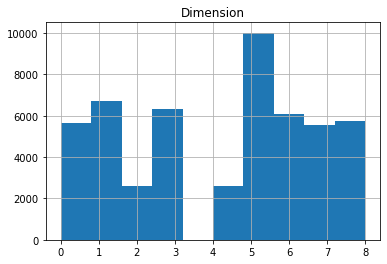

In [2]:
#df = pd.read_csv("../Data/Flujo1.csv", sep=";")
df = pd.read_csv('drive/My Drive/Tesis/Data/Flujo1.csv', sep=";")
df = df[df.Area == 'Social Interno']
df['Respuesta'] = df['Respuesta'].apply(ast.literal_eval)
list_raw_dimensions = df.Dimension.unique().tolist()
def enumerate_dimensions(dimension):
    return list_raw_dimensions.index(dimension)

df['Dimension'] = df.Dimension.apply(enumerate_dimensions)
model = Word2Vec.load('drive/My Drive/Tesis/modelWord2vec.bin')
list_responses = list(df.Respuesta)
list_dimensions = list(df.Dimension)
df.hist('Dimension')

In [0]:
def make_feature_vec(words, model, num_features):
    feature_vec = np.zeros((num_features,),dtype="float32")
    nwords = 0
    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            feature_vec = np.add(feature_vec,model[word])
    feature_vec = np.divide(feature_vec, nwords)
    return feature_vec

def get_avg_feature_vecs(reviews, model, num_features):
    counter = 0
    review_feature_vecs = np.zeros((len(reviews),num_features), dtype='float32')
    for review in reviews:
        review_feature_vecs[counter] = make_feature_vec(review, model, num_features)
        counter = counter + 1
    return review_feature_vecs

In [4]:
num_features = 10
list_responses_vec = get_avg_feature_vecs(list_responses, model, num_features)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [0]:
x_train, x_test, y_train, y_test = train_test_split(list_responses_vec, list_dimensions, test_size = 0.2, random_state = 0)

In [6]:
forest = RandomForestClassifier(n_jobs=3, oob_score = True, max_depth=9, n_estimators=1000, bootstrap = True)
acc = cross_val_score(forest, list_responses_vec, list_dimensions, scoring='accuracy', cv=10)
print(acc)

[0.59147528 0.61378236 0.59053738 0.55851996 0.56962025 0.5873758
 0.56321839 0.53419053 0.48791894 0.49025341]


In [7]:
forest.fit(x_train , y_train)
predicctions = forest.predict(x_test)
score = accuracy_score(y_test ,predicctions)
print("Predicting labels for test data..")
print(classification_report(y_test, predicctions))

Predicting labels for test data..
              precision    recall  f1-score   support

           0       0.50      0.51      0.51      1121
           1       0.68      0.73      0.70      1349
           2       0.55      0.09      0.15       521
           3       0.51      0.59      0.55      1248
           4       0.51      0.06      0.11       515
           5       0.62      0.75      0.68      1975
           6       0.46      0.61      0.53      1253
           7       0.42      0.37      0.39      1112
           8       0.70      0.62      0.66      1175

    accuracy                           0.56     10269
   macro avg       0.55      0.48      0.48     10269
weighted avg       0.56      0.56      0.54     10269



In [9]:
confusion_matrix(y_test, predicctions)

array([[ 572,   39,   11,   60,    2,  158,  173,   72,   34],
       [  27,  989,    2,   46,    1,   64,  111,   65,   44],
       [ 124,   47,   47,   56,    8,   81,   69,   77,   12],
       [  55,   55,    1,  740,    5,  191,  105,   50,   46],
       [  73,   43,    7,   85,   33,   84,  125,   52,   13],
       [  95,   55,    4,  184,    3, 1481,   55,   63,   35],
       [ 105,   78,    4,  105,    4,   86,  767,   73,   31],
       [  66,   92,    9,   98,    6,  157,  176,  413,   95],
       [  26,   59,    1,   66,    3,   97,   76,  118,  729]])

In [8]:
probs = forest.predict_proba(x_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC {:.3f}'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

ValueError: ignored